## Plot searchlight

In [1]:
import pickle
import matplotlib.pyplot as plt 
import numpy as np
from datetime import datetime
from nilearn import image, plotting
from nilearn.plotting import plot_glass_brain, plot_stat_map
from nilearn.image import new_img_like, load_img
from nilearn import image
from nilearn.plotting import plot_stat_map, plot_img, show
from nilearn import plotting

In [2]:
# Getting back the objects:
f = open('/work/807746/emma_folder/notebooks/fMRI/project_repo/notebooks/flms/InSpe_first_level_models_all_trials_searchlight_negpos.pkl', 'rb')
searchlight,searchlight_scores_ = pickle.load(f)
f.close()

# Getting back the objects:
f = open('/work/807746/emma_folder/notebooks/fMRI/project_repo/notebooks/flms/InSpe_first_level_models_testtrain.pkl', 'rb')
fmri_img_train, fmri_img_test, idx_train,idx_test, conditions_train,  conditions_test= pickle.load(f)
f.close()

Plotting and saving searchlight output (threshold:0.6): 08:05:31


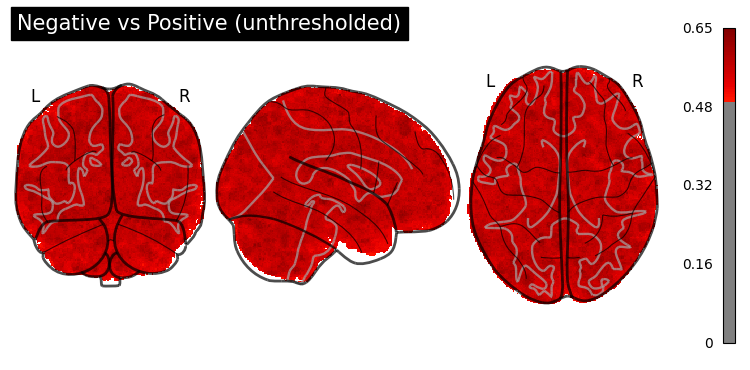

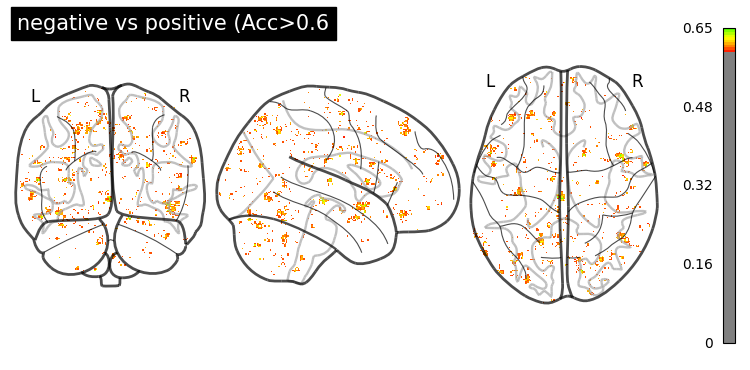

In [3]:
# ## Plot the outcome of the searchlight analysis
mask_wb_filename='/work/816119/InSpePosNegData/BIDS_2023E/derivatives/sub-0117/anat/sub-0117_acq-T1sequence_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'
anat_filename='/work/816119/InSpePosNegData/BIDS_2023E/derivatives/sub-0117/anat/sub-0117_acq-T1sequence_run-1_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz'

now = datetime.now()
print('Plotting and saving searchlight output (threshold:0.6):',now.strftime("%H:%M:%S"))

#Create an image of the searchlight scores
searchlight_img = new_img_like(anat_filename, searchlight.scores_)


plot_glass_brain(searchlight_img, cmap='jet',colorbar=True, threshold=0.5,
                          title='Negative vs Positive (unthresholded)',
                          plot_abs=False)

fig=plotting.plot_glass_brain(searchlight_img,cmap='prism',colorbar=True,threshold=0.60,title='negative vs positive (Acc>0.6')
fig.savefig("/work/807746/emma_folder/notebooks/fMRI/project_repo/notebooks/InSpe_neg_vs_pos_searchlightNB_glass.png", dpi=300)
#plt.show()

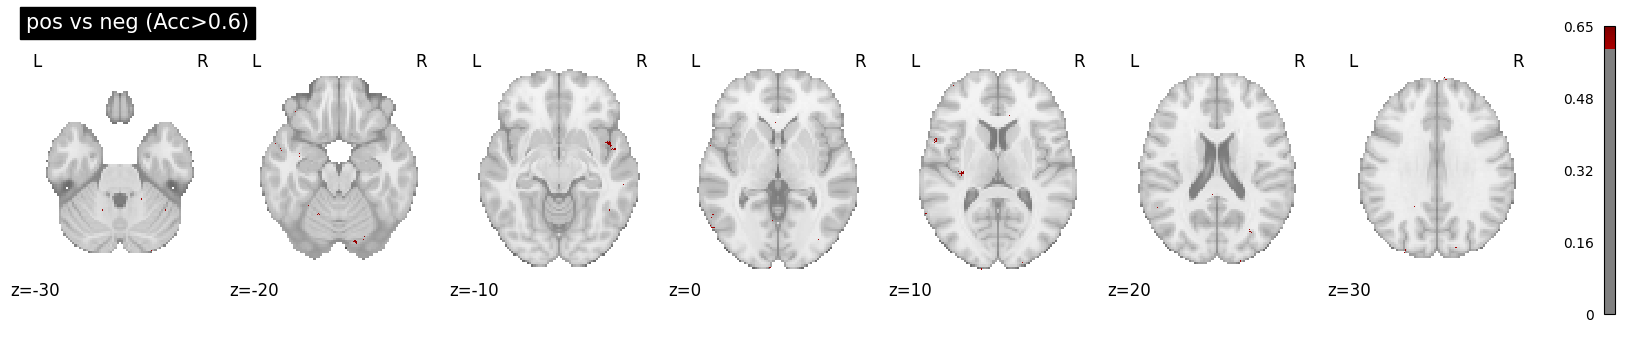

In [4]:
plot_stat_map(searchlight_img, cmap='jet',threshold=0.6, cut_coords=[-30,-20,-10,0,10,20,30],
              display_mode='z',  black_bg=False,
              title='pos vs neg (Acc>0.6)')
plt.show()

In [33]:
# ### Find the 800 most predictive voxels 
print('Number of voxels in searchlight: ',searchlight.scores_.size)
#Find the percentile that makes the cutoff for the 800 best voxels
perc=100*(1-500.0/searchlight.scores_.size)
#Print percentile
print('Percentile for 500 most predictive voxels: ',perc)
#Find the cutoff
cut=np.percentile(searchlight.scores_,perc)
#Print cutoff
print('Cutoff for 500 most predictive voxels: ', cut)
#cut=0

Number of voxels in searchlight:  8980290
Percentile for 500 most predictive voxels:  99.9944322510743
Cutoff for 500 most predictive voxels:  0.6078817733990147


In [34]:
#Make a mask using cutoff
#Load the whole brain mask
mask_img2 = load_img(mask_wb_filename)

# .astype() makes a copy.
process_mask2 = mask_img2.get_fdata().astype(int)
process_mask2[searchlight.scores_<=cut] = 0
process_mask2_img = new_img_like(mask_img2, process_mask2)

/tmp/ipykernel_134/3678468969.py:8: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  process_mask2_img = new_img_like(mask_img2, process_mask2)


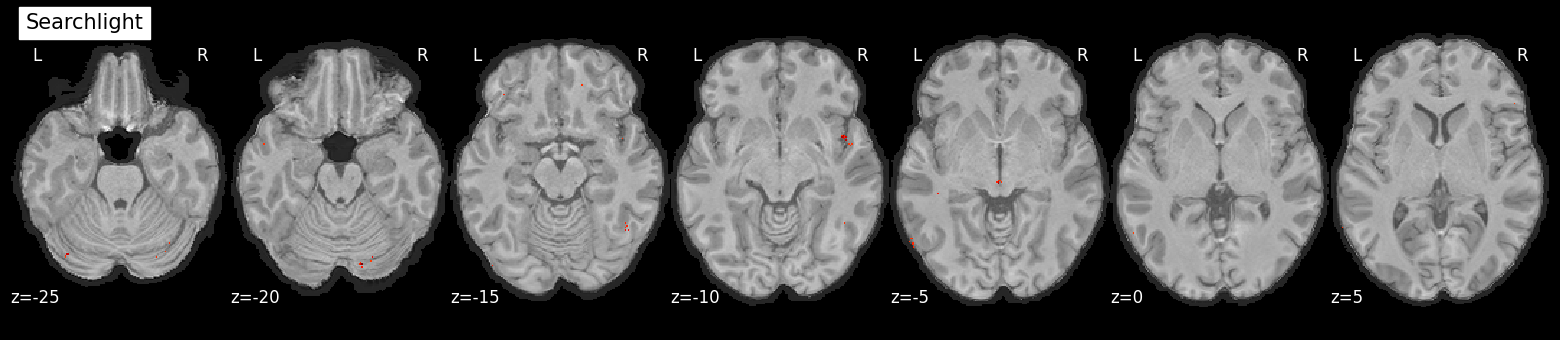

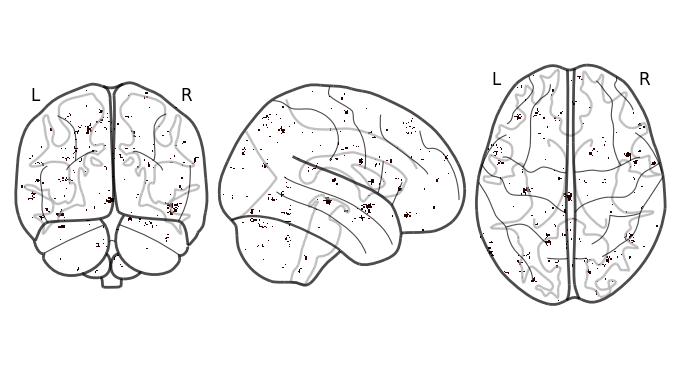

In [35]:
#### Visualization of the voxels

# Create an image of the searchlight scores
searchlight_img = new_img_like(anat_filename, searchlight.scores_)
# Plot the searchlight scores on an anatomical background
plot_img(searchlight_img, bg_img=anat_filename,#bg_img=mean_fmri,
         title="Searchlight", display_mode="z",cut_coords=[-25,-20,-15,-10,-5,0,5],
         vmin=.40, cmap='jet', threshold=cut, black_bg=True)
#plotting.plot_glass_brain effects
fig=plotting.plot_glass_brain(searchlight_img,threshold=cut)
fig.savefig("/work/807746/emma_folder/notebooks/fMRI/project_repo/notebooks/500_InSpe_neg_vs_pos_searchlightNB_glass_800.png", dpi=300)

In [36]:
#### Make a permutation classification test on the 2nd data split using the best voxels
now = datetime.now()
print('Perform permutation test on test set using 500 predictive voxels:',now.strftime("%H:%M:%S"))
from sklearn.naive_bayes import GaussianNB
from nilearn.input_data import NiftiMasker
masker = NiftiMasker(mask_img=process_mask2_img, standardize=False)

# We use masker to retrieve a 2D array ready
# for machine learning with scikit-learn
fmri_masked = masker.fit_transform(fmri_img_test)
#Print size of matrix (images x voxels)
print(fmri_masked.shape)

from sklearn.model_selection import permutation_test_score
score_cv_test, scores_perm, pvalue= permutation_test_score(
    GaussianNB(), fmri_masked, conditions_test, cv=10, n_permutations=1000, 
    n_jobs=-1, random_state=0, verbose=0, scoring=None)
print("Classification Accuracy: %s (pvalue : %s)" % (score_cv_test, pvalue))

Perform permutation test on test set using 500 predictive voxels: 08:21:47


/work/807746/emma_folder/virt_env/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


(72, 499)
Classification Accuracy: 0.6107142857142857 (pvalue : 0.07292707292707293)


In [37]:
with open('/work/807746/emma_folder/notebooks/fMRI/project_repo/notebooks/500permutation_test_results.txt', 'w') as file:
    file.write(f"Classification Accuracy: {score_cv_test} (p-value: {pvalue})\n")

print("Results saved to permutation_test_results.txt")

Results saved to permutation_test_results.txt


Plotting and saving permutation scores: 08:23:40


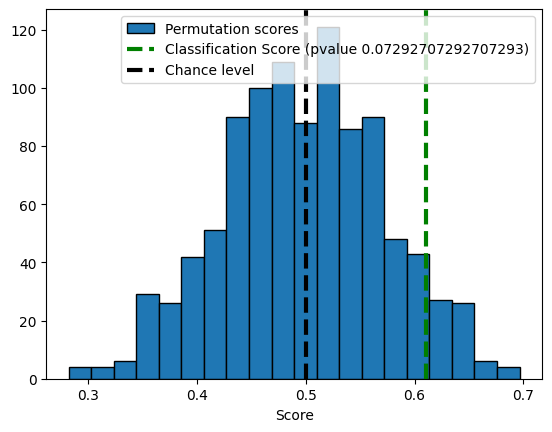

In [38]:
### Saving permutation outcomes
import pickle

# Saving the objects:
f = open('/work/807746/emma_folder/notebooks/fMRI/project_repo/notebooks/500_InSpe_first_level_models_all_trials_searchlight_perms.pkl', 'wb')
pickle.dump([score_cv_test, scores_perm, pvalue], f)
f.close()

# Getting back the objects:
#f = open('/work/MikkelWallentin#6287/InSpe_first_level_models_all_trials_searchlight_perms.pkl', 'rb')
#score_cv_test, scores_perm, pvalue = pickle.load(f)
#f.close()


# ### View a histogram of permutation scores
now = datetime.now()
print('Plotting and saving permutation scores:',now.strftime("%H:%M:%S"))

import numpy as np
import matplotlib.pyplot as plt
# How many classes
n_classes = np.unique(conditions_test).size

plt.hist(scores_perm, 20, label='Permutation scores',
         edgecolor='black')
ylim = plt.ylim()
plt.plot(2 * [score_cv_test], ylim, '--g', linewidth=3,label='Classification Score'
         ' (pvalue %s)' % pvalue)
plt.plot(2 * [1. / n_classes], ylim, '--k', linewidth=3, label='Chance level')

plt.ylim(ylim)
plt.legend()
plt.xlabel('Score')

plt.savefig("/work/807746/emma_folder/notebooks/fMRI/project_repo/notebooks/500_InSpe_neg_vs_pos_one_sub_perm.png", dpi=300)
plt.show()